## Section C2: Bayesian Optimisation with BOTorch

#### BO Overview: 
A BO campaign typically involves the following steps: 

1. Fit a GP surrogate: p(f | D)
2. Build an acquisition function a(x) from the posterior
3. Optimize it (cheap): x_next = argmax a(x)
4. Evaluate the real objective (expensive): y_next = f(x_next)
5. Append (x_next, y_next) to D and repeat

We will first focus on aquisition functions before closing the loop to perform BO. 

### Importing relevant packages
(Feel free to import any packages you feel like needing to fully explore the content!)

In [1]:
import os, math, time, warnings
from typing import Callable, Optional, Tuple, Dict, List

import torch
import matplotlib.pyplot as plt
import numpy as np

import botorch
import gpytorch


print("torch:", torch.__version__)
print("botorch:", botorch.__version__)
print("gpytorch:", gpytorch.__version__)


from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.acquisition.analytic import (
    ExpectedImprovement,
    ProbabilityOfImprovement,
    UpperConfidenceBound,
    PosteriorMean,
    PosteriorStandardDeviation,
)

from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.logei import qLogExpectedImprovement, qLogNoisyExpectedImprovement
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy


c:\Users\leeyo\anaconda3\envs\test_botorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.10.0+cpu
botorch: 0.16.1
gpytorch: 1.15.1


### Set device / dtype and a reproducible random seed

BOTorch uses PyTorch for tensor creation and manipulation. `torch.double` (float64) used for numerical stability. Default of Pytorch is float32. Allows numerical values to have 16 decimal digits rather than 7. Instability could manifest as the following errors: 

- RuntimeError: cholesky_cpu: ... not positive definite
- NaNs in the marginal log likelihood during fitting
- wildly oscillating hyperparameters
- acquisition values becoming NaN or inf


However, float64 makes code execution slower. For scaling up/big projects, try float32, but be weary of instaibility/adding some error handling. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

tkwargs = {"device": device, "dtype": dtype}

def set_seed(seed: int = 0):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)
print("device:", device, "| dtype:", dtype)


device: cpu | dtype: torch.float64


### Aquisition Functions 

An acquisition function is a **cheap** to evaluate scoring function that tells us where to sample next. The role of the acquisition function is to obtain a set of un-evaluated set of input values with the highest utility (that is the 'best' point which the user should evaluate) towards obtianing the optimum. In other words, an acquisition function `a(x)` maps a candidate input `x` to a score:
- higher score = more attractive to evaluate next

In section B2, we were asked to ponder about how the output of the GP regressor (the predicted mean and the associated standard deviation) can help us in this endeavour. 

In the two extremes, acquisition functions can be made to either fully exploit or fully explore the system. 
- full exploit: evaluate where the posterior mean is the highest.
- full explore: evaluate where the posterior standard deviation is the highest. 

For practical applications, a balance between exploitation and exploration is desired to obtain optimial values with the least amount of resources. The following section will take us through popular aquisition functions used. 


In [3]:
# Helper functions - please execute

def eval_acq_on_grid(acqf, X_grid: torch.Tensor) -> torch.Tensor:
    # Try MC-style call first: (n,1,d)
    try:
        return acqf(X_grid.unsqueeze(1)).squeeze(-1)
    except Exception:
        # Fallback to analytic-style call: (n,d)
        return acqf(X_grid).squeeze(-1)

def plot_acq_1d(acqf, title: str, bounds: torch.Tensor, train_X: torch.Tensor, train_Y: torch.Tensor, model: SingleTaskGP):
    X_grid = torch.linspace(bounds[0,0].item(), bounds[1,0].item(), 400, **tkwargs).unsqueeze(-1)

    model.eval()
    with torch.no_grad():
        post = model.posterior(X_grid)
        mu = post.mean.squeeze(-1)
        sd = post.variance.sqrt().squeeze(-1)
        acq = eval_acq_on_grid(acqf, X_grid)

    best_idx = torch.argmax(acq)
    x_next = X_grid[best_idx:best_idx+1]

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    axes[0].scatter(train_X.detach().cpu().squeeze(-1), train_Y.detach().cpu().squeeze(-1), label="data")
    axes[0].plot(X_grid.detach().cpu().squeeze(-1), mu.detach().cpu(), label="posterior mean")
    axes[0].fill_between(
        X_grid.detach().cpu().squeeze(-1),
        (mu - 2*sd).detach().cpu(),
        (mu + 2*sd).detach().cpu(),
        alpha=0.2,
        label="±2σ",
    )
    axes[0].axvline(x_next.item(), linestyle="--")
    axes[0].set_title("GP posterior")
    axes[0].legend()

    axes[1].plot(X_grid.detach().cpu().squeeze(-1), acq.detach().cpu())
    axes[1].axvline(x_next.item(), linestyle="--", label="argmax")
    axes[1].set_title(title)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("acq(x)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


### Setting the Context

We will be using the following objective function as our optimisation case study. 

$$
f(x) \;=\; \sin(2\pi x)\;+\;0.3\,\cos(6\pi x)\;+\;0.1x
$$

With an initial training datset of 3 points. Our goal is to obtain the next best input to evaluate such that we obtain the optimum within a minimum amount of resources/steps. Optimisation here is framed as maximisation. (BoTorch assumes maximization. If your real problem is minimization, negate your objective.)

Similar to section B2, we will define the objective function, obtain 3 samples of the objective function (initial training points) and perform GP regression (default RBF kernel used). 

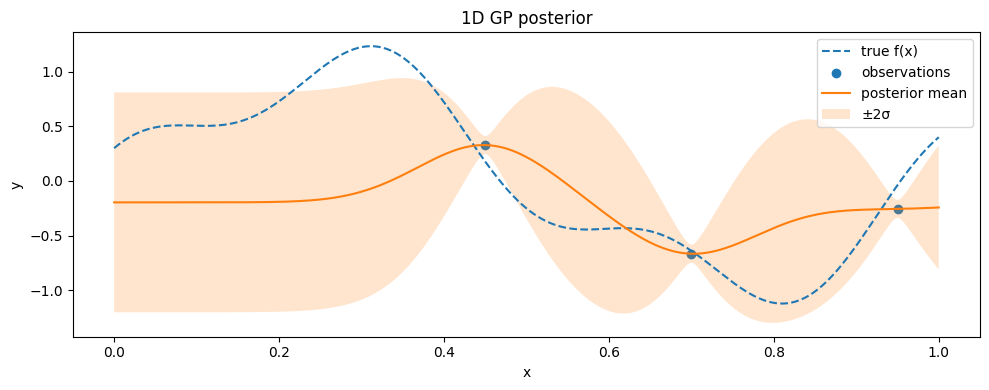

In [4]:
def true_f_1d(x: torch.Tensor) -> torch.Tensor:
    # A smooth 1D function defined on [0, 1].
    # x: (..., 1) tensor -> returns (..., 1) tensor
    return (torch.sin(2 * math.pi * x) + 0.3 * torch.cos(6 * math.pi * x) + 0.1 * x).to(**tkwargs)

def observe_noisy(fx: torch.Tensor, noise_std: float = 0.10) -> torch.Tensor:
    return fx + noise_std * torch.randn_like(fx)

def fit_gp_1d(train_X: torch.Tensor, train_Y: torch.Tensor) -> SingleTaskGP:
    model = SingleTaskGP(
        train_X,
        train_Y,
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

# Initial data
n_init = 3
train_X = torch.linspace(0.45, 0.95, n_init, **tkwargs).unsqueeze(-1)  # (n,1)
train_Y_true = true_f_1d(train_X)
train_Y = observe_noisy(train_Y_true, noise_std=0.10)

# Dense grid for plotting
test_X = torch.linspace(0.0, 1.0, 400, **tkwargs).unsqueeze(-1)
test_Y_true = true_f_1d(test_X)

model = fit_gp_1d(train_X, train_Y)

model.eval()
with torch.no_grad():
    post = model.posterior(test_X)
    mu = post.mean.squeeze(-1)
    sd = post.variance.sqrt().squeeze(-1)


# Plot: true function, noisy observations, GP posterior mean ± 2σ
plt.figure(figsize=(10, 4))
plt.plot(test_X.detach().cpu().squeeze(-1), test_Y_true.detach().cpu().squeeze(-1), linestyle="--", label="true f(x)")
plt.scatter(train_X.detach().cpu().squeeze(-1), train_Y.detach().cpu().squeeze(-1), label="observations")
plt.plot(test_X.detach().cpu().squeeze(-1), mu.detach().cpu(), label="posterior mean")
plt.fill_between(
    test_X.detach().cpu().squeeze(-1),
    (mu - 2 * sd).detach().cpu(),
    (mu + 2 * sd).detach().cpu(),
    alpha=0.2,
    label="±2σ",
)
plt.title("1D GP posterior")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


### Aquisition Function Overview
There are two big families:

#### Analytic acquisitions (closed form)
These are acquisitions where BoTorch can compute the value exactly. 
- EI (Expected Improvement)
- PI (Probability of Improvement)
- UCB (Upper Confidence Bound)

Analytical acquisition are comparatively faster to compute and deterministic. However, they do not lend themselves immediately well to multi-batch settings (only one point proposed at a time). 


#### Monte Carlo (MC) acquisitions
These compute acquisitions by approximating an expectation using samples from the model posterior.
- qEI (batch EI)
- qNEI (noisy EI)
- qLogEI / qLogNEI (numerically stable log-versions)
- Knowledge Gradient (KG)
- Max-value Entropy Search (MES)

MC aquisitions can be used for much more general setting (multi-batch, noisy, complex objectives). However, they are generally slower as sampling is required and are not deterministic. In BoTorch, MC acquisitions are typically differentiable, so we can optimize them with gradients.

#### 1. Full Exploitation and Exploration

As mentioned above, we can obtain fully explotative or explorative aquisition functions by invoking the posterior mean or standard deviation. 

We have seen in section B2 how these values can be obtained. However, there is a simpler method using the `botorch.acquisition.analytic`. These also translate for other aquisition functions that are built into BOTorch. 

For aquisition functions, we can directly pass our GP model object into the aquisition function class. The next best value is simply the maximum of this plot. For example: 

```python 
from botorch.acquisition.analytic import (
    PosteriorMean,
    PosteriorStandardDeviation,
)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

acq_mean = PosteriorMean(model)
plot_acq_1d(acq_mean, "PosteriorMean (exploit)", bounds_1d, train_X, train_Y, model)

```
Comments: 
- `plot_acq_1d()` - helper function that plots the GP posterior and the aquisition function graphs. The inputs are `(acqf, title: str, bounds: torch.Tensor, train_X: torch.Tensor, train_Y: torch.Tensor, model: SingleTaskGP)`

#### Exercise 1_1

Execute the above to observe `PosteriorMean` as the aquisition function.

Then modify the code to use the `PosteriorStandardDeviation` as the aquisition function. 

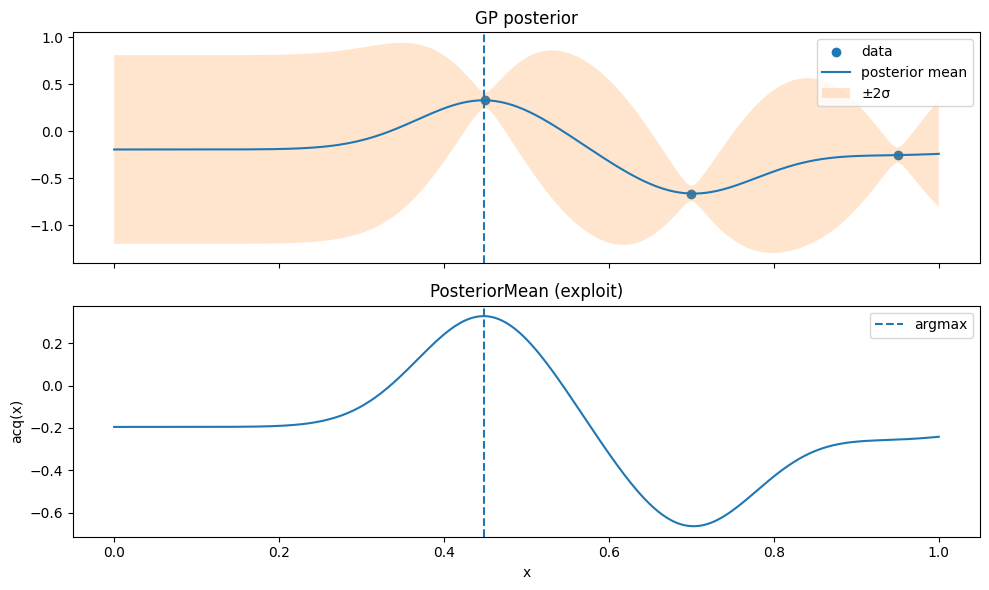

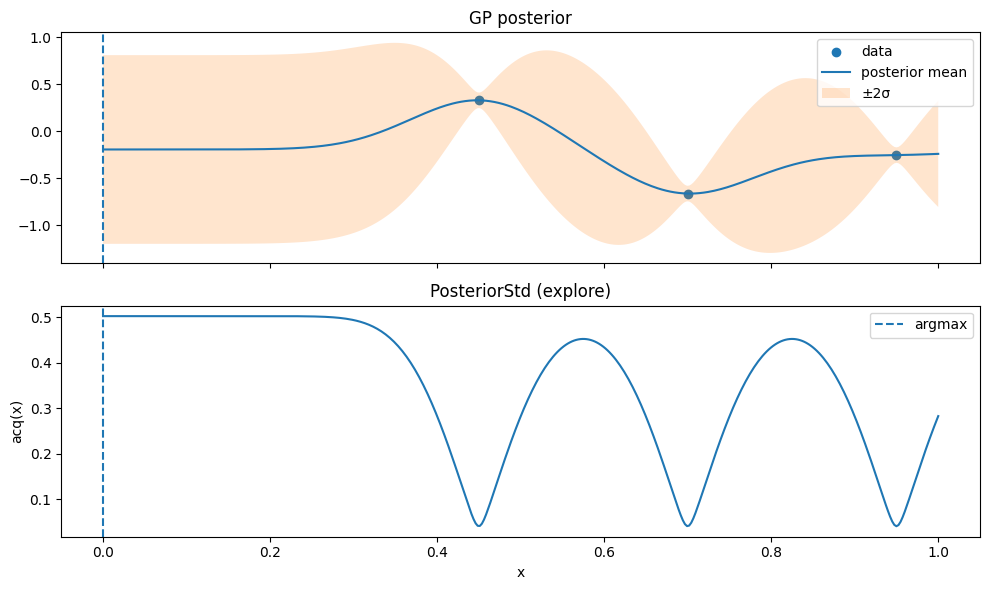

In [5]:
from botorch.acquisition.analytic import (
    PosteriorMean,
    PosteriorStandardDeviation,
)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

acq_mean = PosteriorMean(model)
plot_acq_1d(acq_mean, "PosteriorMean (exploit)", bounds_1d, train_X, train_Y, model)

acq_std = PosteriorStandardDeviation(model)
plot_acq_1d(acq_std, "PosteriorStd (explore)", bounds_1d, train_X, train_Y, model)



#### 2. Analytic Aquisition Functions

##### Upper Confidence Bound (UCB)

UCB combines the posterior mean and std into a single utility score. 

$$
\mathrm{UCB}(x) = \mu(x) + \beta\,\sigma(x)
$$

- 𝛽 parameter the degree of exploration as it diminishes/amplifies the standard deviation contribution by a factor

#### Exercise 2_1 

UCB aquisition function can be simply performed with the object below (observe the need for the beta parameter).

```python
from botorch.acquisition.analytic import (    UpperConfidenceBound)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

acq_ucb = UpperConfidenceBound(model, beta=0.2)
plot_acq_1d(acq_ucb, "UCB (beta=0.2)", bounds_1d, train_X, train_Y, model)
```

Try different `beta` values for UCB (e.g., 0.05, 0.2, 1.0. etc).  What happens to the exploration behavior?

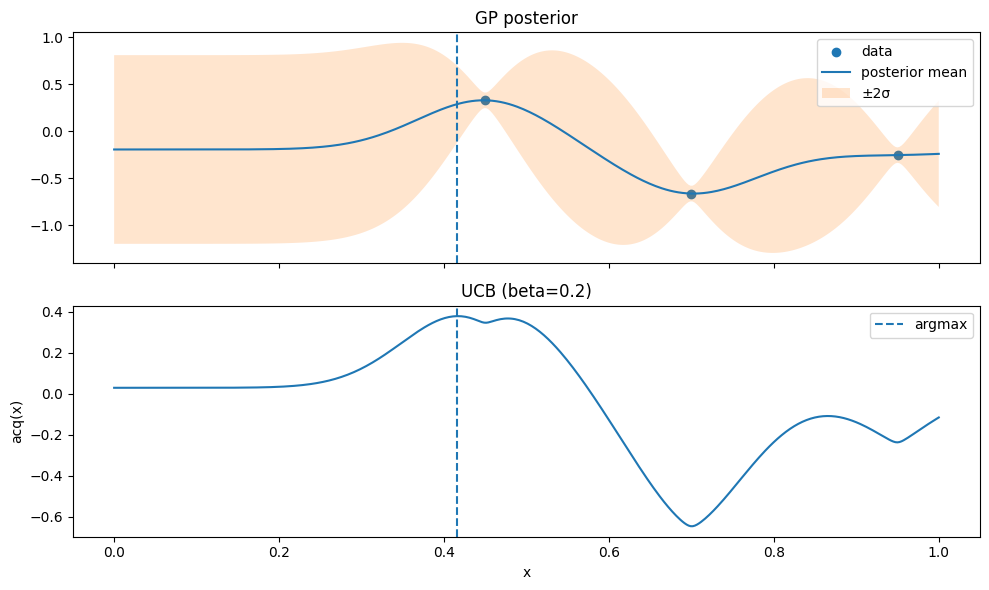

In [6]:
bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

acq_ucb = UpperConfidenceBound(model, beta=0.2)
plot_acq_1d(acq_ucb, "UCB (beta=0.2)", bounds_1d, train_X, train_Y, model)


#### Probability of Improvement (PI)

Intuitively, PI answers: At this 𝑥, what’s the probability the objective will be better than what we’ve seen so far?

PI is formulated as: 
$$
\mathrm{PI}(x) = \Pr\!\left(f(x) \ge f_{\text{best}} + \xi\right)
$$

where 𝜉 encourages exploration. 

Becuase 𝑓(𝑥) is Gaussian under the GP posterior, 

$$
f(x)\mid \mathcal{D} \sim \mathcal{N}\!\big(\mu(x), \sigma^2(x)\big)
$$

PI has a closed form. We can then obtain the solution through the standardized variable $Z(x)$ where $f_{\text{best}}$ is the current best output value.

$$
Z(x) = \frac{\mu(x) - \left(f_{\text{best}} + \xi\right)}{\sigma(x)}
$$

Then, obtain the standard normal cumilative distribution function. 

$$
\mathrm{PI}(x) = \Phi\!\left(Z(x)\right)
$$

- If μ(x) is well above the threshold → PI near 1.
- If σ(x) is large (high uncertainty) → PI can be moderately high even if μ(x) isn’t huge.
- If σ(x) is tiny and μ(x) is below threshold → PI near 0.

PI maximizes probability of beating the best seen so far. However, it is observed that PI often prefer points that have a moderate chance of a tiny improvement over points that have a smaller chance of a big improvement. This is why expected improve is prefered as the aquisition function maximizes expected amount of improvement. 

#### Exercise 2_2

PI aquisition function can be simply performed with the object below.

```python
from botorch.acquisition.analytic import (    ProbabilityOfImprovement)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

tau = 0.1
acq_pi = ProbabilityOfImprovement(model, best_f=best_f + tau)
plot_acq_1d(acq_pi, "PI (Probability of Improvement)", bounds_1d, train_X, train_Y, model)
   
```

Try different `tao` values for PI. What happens to the exploration behavior?

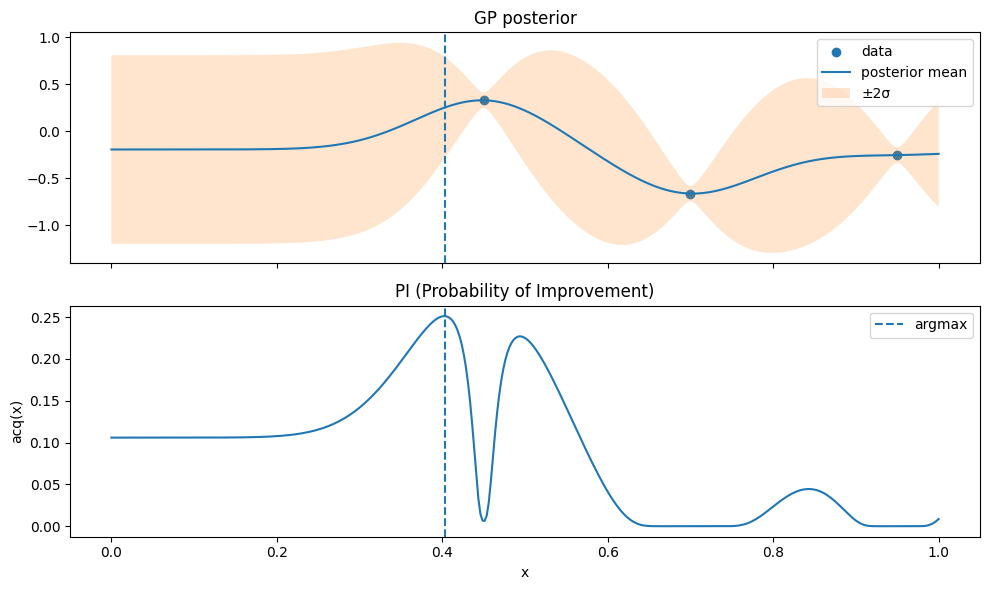

In [7]:
from botorch.acquisition.analytic import (    ProbabilityOfImprovement)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

tau = 0.1
acq_pi = ProbabilityOfImprovement(model, best_f=best_f + tau)
plot_acq_1d(acq_pi, "PI (Probability of Improvement)", bounds_1d, train_X, train_Y, model)

#### Expected Improvement (EI)

Intuitively, EI answers: How much improvement do I expect at x?

Since at every candidate point x is Gaussian under the GP posterior, 

$$
f(x)\mid \mathcal{D} \sim \mathcal{N}\!\big(\mu(x), \sigma^2(x)\big)
$$

We can define the expected improvement as the expectation value of the improvement random variable $I(x)$ with 𝜉 encouring exploration. 

$$
\mathrm{EI}(x) = \mathbb{E}\!\left[I(x)\right]
$$

where: 

$$
I(x) = \max\!\left(0,\; f(x) - \left(f_{\text{best}} + \xi\right)\right)
$$

- max with 0 enforces the idea that if sampling at x does not beat the threshhold $f(x) - f_{\text{best}}$, then the improvement is 0 instead of negative

The closed-form EI would be: 

$$
\mathrm{EI}(x) = \Delta(x)\,\Phi\!\big(Z(x)\big) + \sigma(x)\,\phi\!\big(Z(x)\big)
$$

with 

$$
\Delta(x) = \mu(x) - \left(f_{\text{best}} + \xi\right)
\qquad \text{and} \qquad
Z(x) = \frac{\Delta(x)}{\sigma(x)}.
$$

- $\Phi$ is the standard normal CDF  
- $\phi$ is the standard normal PDF

Therefore, 
- If $\mu(x)$ is far below $f_{\text{best}}$ and $\sigma(x)$ is small, then $\mathrm{EI}(x) \approx 0$.

- If $\mu(x)$ is above $f_{\text{best}}$, then $\mathrm{EI}(x)$ is large (exploitation).

- If $\sigma(x)$ is large, then the $\sigma(x)\,\phi(Z)$ term gives $\mathrm{EI}(x)$ value even when the mean isn’t best (exploration).


EI prefers points that either:
- have high mean (likely good), or
- have high uncertainty (could be much better than best)


#### Exercise 2_3

EI aquisition function can be simply performed with the object below.

```python 
from botorch.acquisition.analytic import (    ExpectedImprovement)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

tao = 0.1
acq_ei = ExpectedImprovement(model, best_f=best_f + tao)
plot_acq_1d(acq_ei, "EI (Expected Improvement)", bounds_1d, train_X, train_Y, model)
```

Try different `tao` values for EI. What happens to the exploration behavior?

c:\Users\leeyo\anaconda3\envs\test_botorch\lib\site-packages\botorch\acquisition\analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


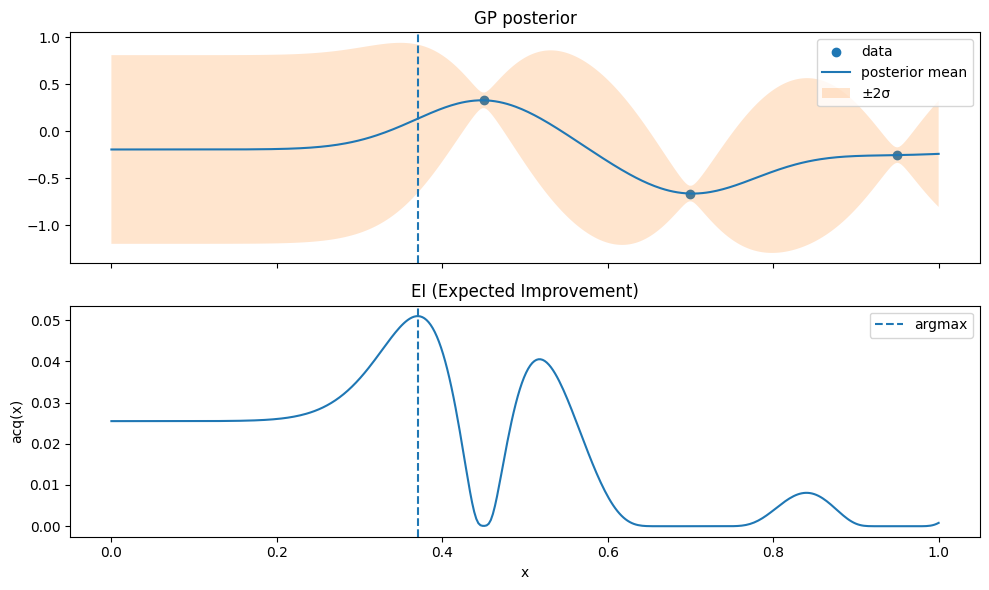

In [8]:
from botorch.acquisition.analytic import (    ExpectedImprovement)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

tao = 0.1
acq_ei = ExpectedImprovement(model, best_f=best_f + tao)
plot_acq_1d(acq_ei, "EI (Expected Improvement)", bounds_1d, train_X, train_Y, model)

#### Log Expected Improvement - Analytical (LogEI)

You might have observed a warning when you ran the previous code on EI. 

```python
NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)

```
EI in this formulation is known to suffer from numerical stability issues especially when the EI values are very small. For example, for values of x where: 

- $\Delta(x)$ small (mean close to best), and/or  
- $\sigma(x)$ small (model very confident)

Then $\mathrm{EI}(x)$ becomes tiny (close to $0$). Computing $\Phi(Z)$ and $\phi(Z)$ and combining terms can hit:

- underflow porblems (values round to 0)
- catastrophic cancellation (loss of precision)
- bad gradients (zero/NaN)

A more numericall stable version of EI would be to simply take the log - LogEI. 

$$
\mathrm{LogEI}(x) = \log\!\left(\mathbb{E}\left[\max\!\left(f(x) - f_{\text{best}},\, 0\right)\right]\right)
$$

This can be simply implimented.

```python 
from botorch.acquisition.analytic import (LogExpectedImprovement)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

tao = 0.1
acq_logei = LogExpectedImprovement(model, best_f=best_f + tao)
plot_acq_1d(acq_logei, "Analytic LogEI", bounds_1d, train_X, train_Y, model)

```


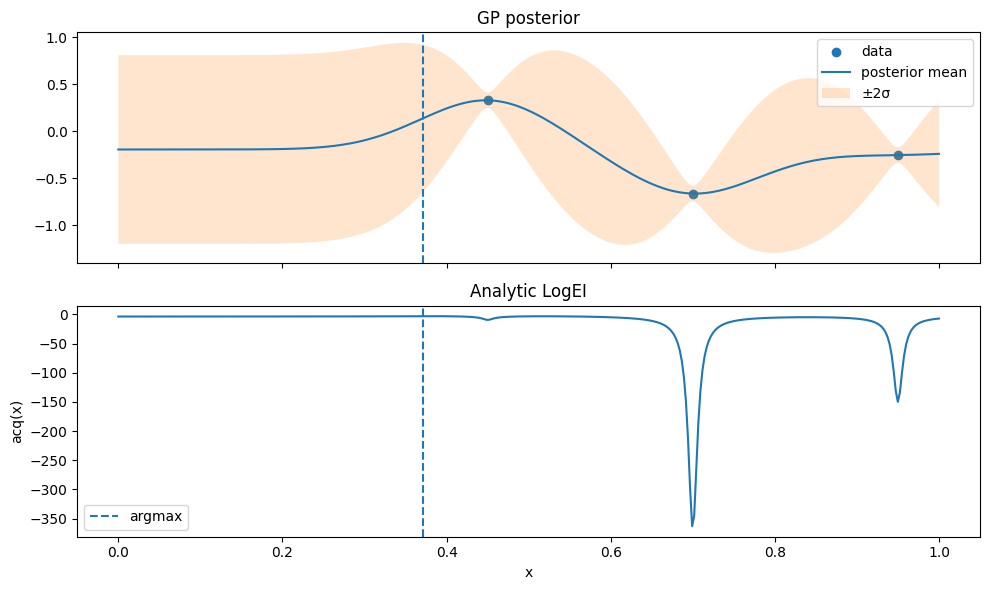

In [9]:
from botorch.acquisition.analytic import (LogExpectedImprovement)

bounds_1d = torch.tensor([[0.0], [1.0]], **tkwargs)
best_f = train_Y.max()

tao = 0.1
acq_logei = LogExpectedImprovement(model, best_f=best_f + tao)
plot_acq_1d(acq_logei, "Analytic LogEI", bounds_1d, train_X, train_Y, model)

### 3. Optimising acquisition functions 

Previously, we take the maximum of the aquisition function using `argmax()` to be the chosen candidate point. However, as the previously seen acquisition function is built on top of a tensor grid `torch.linspace()`, the `argmax()` maximum is seldom the true maximum, especially when the tensor grid is not fine. 

We can use `optimize_acqf()` to obtian the true maximum of the aquisition function. `optimize_acqf()` does this with a multi-start local optimisation and can be used for both single point and batch aquisition functions. (`q` denotes batch size.)

The workflow is as follows: 
1. Generate initial starting points by drawing `raw_samples` number of points in the space defined by `bounds` with sobol sampling
2. From these points, pick `num_restarts` starting locations
3. Locally optimise the acquisition function starting from each of the `num_restarts` initial conditions

Example with UCB acquisition function: 
```python
def propose_next_point(acqf, bounds: torch.Tensor, q: int = 1):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=q,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, acq_value

acq_ucb = UpperConfidenceBound(model, beta=0.2)
x_next_ucb, val_ucb = propose_next_point(acq_ucb, bounds_1d, q=1)
print("UCB x_next:", x_next_ucb.detach().cpu().numpy(), "acq:", val_ucb.item())

```


In [11]:
from botorch.optim import optimize_acqf

def propose_next_point(acqf, bounds: torch.Tensor, q: int = 1):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=q,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, acq_value

acq_ucb = UpperConfidenceBound(model, beta=0.2)
x_next_ucb, val_ucb = propose_next_point(acq_ucb, bounds_1d, q=1)
print("UCB x_next:", x_next_ucb.detach().cpu().numpy(), "acq:", val_ucb.item())


UCB x_next: [[0.4168074]] acq: 0.37885813607088037


### 4. MC Acquisitions and Batch Bayesian Optimisation

MC acquisitions approximate the utility of candidate points via drawing samples from the posterior. Typically, a workflow for an MC acquisition involves (i) sampling the posterior a number of times (obtaining plausible outcomes for the batch) (ii) compute for the improvement for the batch of samples (iii) average the improvement over many samples. 

This is lends well for applications where there is no closed-form expression for the acquisition functions seen previously. For example, for batch selection `q > 1`. 

In BOTorch, most MC aquisition functions inherit from a  base class `MCAcquisitionFunction` that takes in: a model (often GP model) and a sampler (how the posterior is sampled - ex. SOBOL (random) sampling), then evaluates the aquisition `acq(X)` where `X` has tensor shape `b x q x d` number of candidate batches to evaluate at once x batch size x number of dimensions. 

#### Batch Expected Improvement (qEI)

qEI could be performed for the single batch case, but it is perhaps more useful and quicker to use the analytical acquisition functions. Here, we start to discuss in the context of multi-batch applications. 

qEI chooses a set of points $X = \{x_1, \ldots, x_q\}$ to evaluate in parallel and obtains an expectation value for improvement over the set of points. 

The parallel evaluation is required as the GP posterior over set `X` is joint. The predictions are correlated via the correlation matrix $\Sigma(X)$.

$$
f(X)\mid \mathcal{D} \sim \mathcal{N}\!(\mu(X),\, \Sigma(X))
$$

The expectation value for the expected improvment of the whole batch is given by the value $x_n$ which has the highest improvement. 

$$
q\mathrm{EI}(X)
=
\mathbb{E}\Big[
\max\big(
\max(Y_1,\ldots,Y_q)-f_{\text{best}},
\,0
\big)
\Big]
$$




#### qEI with BOTorch

We can easily perform qEI with BOTorch.

```python
qei = qExpectedImprovement(model=model, best_f=train_Y.max(), sampler=sampler)
```
which takes in the model, best observed value and the sampler. The underlying workflow for `qExpectedImprovement` in BOTorch is as follows: 
1. Compute the joint posterior from the model at all q points
2. Draw MC samples from the joint posterior
3. Compute expected improvement per sample, take the best in the batch
4. Average accross all samples to obtain the MC estimate of the expected improvement. 

The recommended sampler uses `SobolQMCNormalSampler()`. For example, 

```python 
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))
```

creates an object that will generate a quasi-random (sobol) 256 MC samples (sets of plausible outcomes for candidate points) of the model's predicted outcomes whenever the aquisition function is evaluated. 

Using `optimisize_acqf()` we can then obtain the next condidate points. 


Similar to before, the qlogEI is also avaiable via 

```python
from botorch.acquisition.logei import qLogExpectedImprovement
```


A full example of qEI: 

```python
from botorch.sampling.normal import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))
best_f = train_Y.max()

def propose_next_point(acqf, bounds: torch.Tensor, q: int = 1):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=q,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, acq_value

# Batch qEI (q=2)
qei = qExpectedImprovement(model=model, best_f=train_Y.max(), sampler=sampler)
Xcand, _ = propose_next_point(qei, bounds_1d, q=2)
Xcand = Xcand.detach()

print("qEI batch candidates:", Xcand.squeeze(-1).cpu().numpy())

model.eval()
with torch.no_grad():
    post = model.posterior(test_X)
    mu = post.mean.squeeze(-1)
    sd = post.variance.sqrt().squeeze(-1)

plt.figure(figsize=(10, 4))
plt.scatter(train_X.cpu().squeeze(-1), train_Y.cpu().squeeze(-1), label="data")
plt.plot(test_X.cpu().squeeze(-1), mu.cpu(), label="posterior mean")
plt.fill_between(test_X.cpu().squeeze(-1), (mu-2*sd).cpu(), (mu+2*sd).cpu(), alpha=0.2, label="±2σ")
for i, x in enumerate(Xcand):
    plt.axvline(x.item(), linestyle="--", label=f"candidate {i+1}")
plt.title("qEI batch candidates (q=2) on GP posterior")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

```


c:\Users\leeyo\anaconda3\envs\test_botorch\lib\site-packages\botorch\acquisition\monte_carlo.py:400: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


qEI batch candidates: [0.50766227 0.3824962 ]


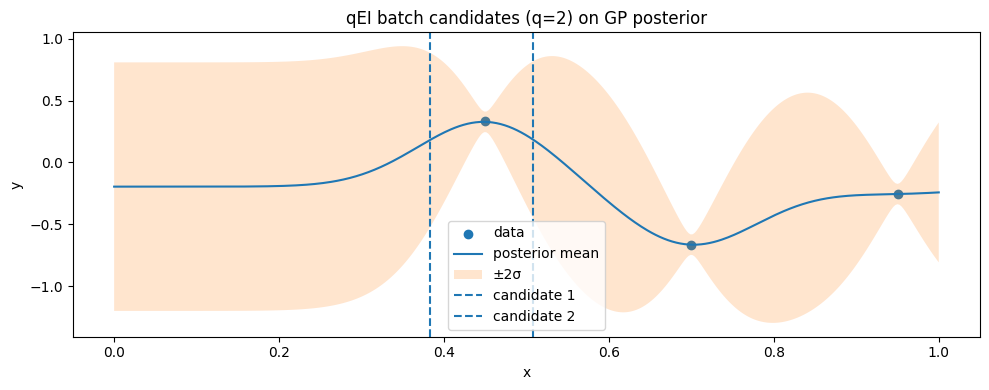

In [12]:
from botorch.sampling.normal import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))
best_f = train_Y.max()

def propose_next_point(acqf, bounds: torch.Tensor, q: int = 1):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=q,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, acq_value

# Batch qEI (q=2)
qei = qExpectedImprovement(model=model, best_f=train_Y.max(), sampler=sampler)
Xcand, _ = propose_next_point(qei, bounds_1d, q=2)
Xcand = Xcand.detach()

print("qEI batch candidates:", Xcand.squeeze(-1).cpu().numpy())

model.eval()
with torch.no_grad():
    post = model.posterior(test_X)
    mu = post.mean.squeeze(-1)
    sd = post.variance.sqrt().squeeze(-1)

plt.figure(figsize=(10, 4))
plt.scatter(train_X.cpu().squeeze(-1), train_Y.cpu().squeeze(-1), label="data")
plt.plot(test_X.cpu().squeeze(-1), mu.cpu(), label="posterior mean")
plt.fill_between(test_X.cpu().squeeze(-1), (mu-2*sd).cpu(), (mu+2*sd).cpu(), alpha=0.2, label="±2σ")
for i, x in enumerate(Xcand):
    plt.axvline(x.item(), linestyle="--", label=f"candidate {i+1}")
plt.title("qEI batch candidates (q=2) on GP posterior")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


#### Batch Noisy Expeccted Improvement (qNEI)

qNEI works when observations are noisy. Instead of requiring a best observed value `best_f` (not well defined under noise), qNEI compares condidates against samples of the latent function values at the previously-evaluated points (already known and evaluated points) termed `X_baseline`. Here, qNEI draws MC samples from the joint posterior over both the candidate batch `X` (size `q`) and baseline points `X_baseline` (size `m`). 

For one MC sample, the acquisition function computes

$$
I_s(X)=\max\left(0,\ \max f_s(X)\;-\;\max f_s\!\left(X_{\text{baseline}}\right)\right)
$$

then averages across samples. 

$$
q\mathrm{NEI}(X)=\mathbb{E}_s\!\left[I_s(X)\right]
$$

We can observe that the 'best observed value' is a random variable induced by the posterior at the already evaluated points. 

Example of qNEI and qlogNEI:

```python 
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.logei import qLogNoisyExpectedImprovement

train_X_n = torch.linspace(0.45, 0.95, 3, **tkwargs).unsqueeze(-1)
train_Y_n = observe_noisy(true_f_1d(train_X_n), noise_std=0.20)

model_n = fit_gp_1d(train_X_n, train_Y_n)
model_n.eval()

X_baseline = train_X_n
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

qnei = qNoisyExpectedImprovement(model=model_n, X_baseline=X_baseline, sampler=sampler)


qlognei = qLogNoisyExpectedImprovement(model=model_n, X_baseline=X_baseline, sampler=sampler)


plot_acq_1d(qnei, "qNEI (noisy expected improvement)", bounds_1d, train_X_n, train_Y_n, model_n)
plot_acq_1d(qlognei, "qLogNEI (recommended, numerically stable)", bounds_1d, train_X_n, train_Y_n, model_n)
```

c:\Users\leeyo\anaconda3\envs\test_botorch\lib\site-packages\botorch\acquisition\monte_carlo.py:502: NumericsWarning: qNoisyExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qNoisyExpectedImprovement 	 --> 	 qLogNoisyExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


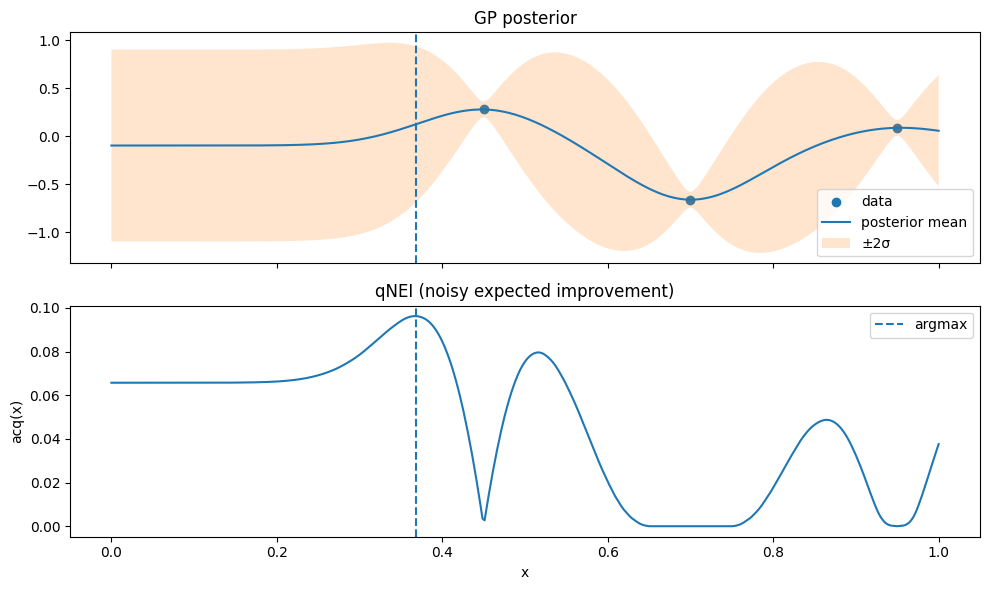

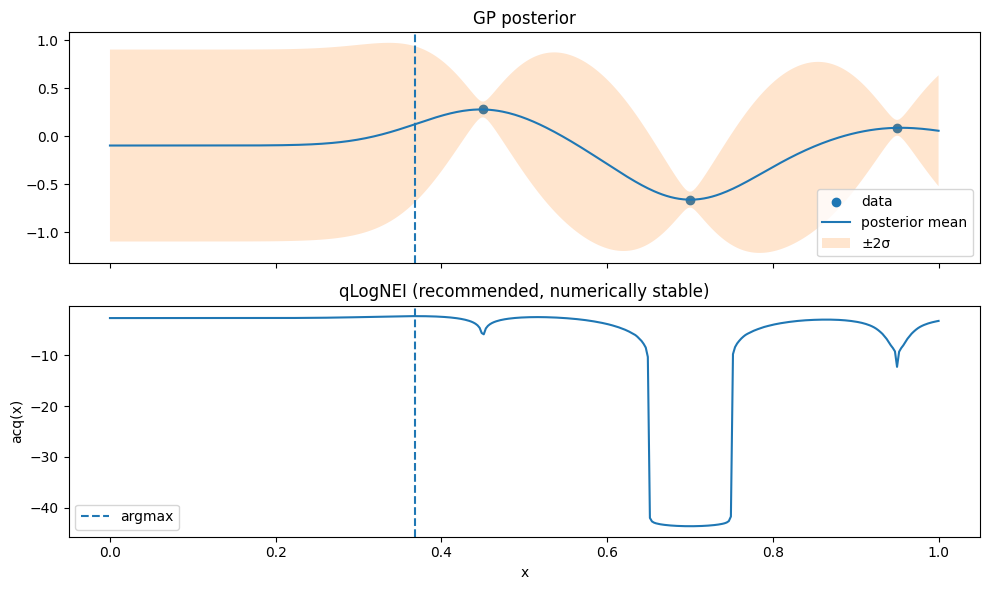

In [15]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.logei import qLogNoisyExpectedImprovement

train_X_n = torch.linspace(0.45, 0.95, 3, **tkwargs).unsqueeze(-1)
train_Y_n = observe_noisy(true_f_1d(train_X_n), noise_std=0.20)

model_n = fit_gp_1d(train_X_n, train_Y_n)
model_n.eval()

X_baseline = train_X_n
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

qnei = qNoisyExpectedImprovement(model=model_n, X_baseline=X_baseline, sampler=sampler)

qlognei = qLogNoisyExpectedImprovement(model=model_n, X_baseline=X_baseline, sampler=sampler)


plot_acq_1d(qnei, "qNEI (noisy expected improvement)", bounds_1d, train_X_n, train_Y_n, model_n)
plot_acq_1d(qlognei, "qLogNEI (recommended, numerically stable)", bounds_1d, train_X_n, train_Y_n, model_n)


#### Information-based/Lookahead acquisition functions

There are 2 popular information-based acquisition functions: 

- Knowledge Gradient (KG/qKG)
- Max-value Entropy Search (MES/qMES)

Instead of scoring a conditate by 'how good it might be under the current posterior' - (ex. EI, UCB, PI), information-based methods score a candidate by how much it teaches you about the optimum (or how much it improves your future decision after you learn something).

These can be accessed using BOTorch via:

```python
    from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
    from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
```

The details are beyond the scope of this notebook. To learn more, visit: 
- https://botorch.org/docs/tutorials/one_shot_kg/
- https://botorch.org/docs/tutorials/max_value_entropy/ 


### 5. Full Bayesian Optimisation Loop

We now have a good foundation to construct a full closed loop BO workflow with BOTorch! As a reminder, the workflow consists of: 

1. Fiting a GP surrogate
2. Build an acquisition function from the GP posterior
3. Optimize the acquisition function to obtain candidate points
4. Evaluate the objective at chosen candidate points
5. Append to training dataset and repeat until termination criteria reached. 

#### Exercise 5_1 

Below is an example of a closed loop BO for 1-D function. Can you identify which sections of code relates to each of the BO workflow listed above? 

Benchmarking exercise: Modify the code to test different acquisition functions with different objective functions and number of starting points. Which acquisition function provides better results?

```python 
import torch
import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.optim import optimize_acqf


def fit_gp_1d(train_X: torch.Tensor, train_Y: torch.Tensor) -> SingleTaskGP:
    model = SingleTaskGP(
        train_X,
        train_Y,
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


def plot_gp_and_acq_1d(
    model,
    acq,
    X,
    Y,
    bounds,
    iteration: int,
    X_next=None,
    true_f=None,
    n_grid: int = 400,
):
    model.eval()
    lb = bounds[0, 0].item()
    ub = bounds[1, 0].item()
    X_grid = torch.linspace(lb, ub, n_grid, **tkwargs).unsqueeze(-1)

    with torch.no_grad():
        post = model.posterior(X_grid)
        mean = post.mean.squeeze(-1)
        std = post.variance.sqrt().squeeze(-1)

        acq_vals = acq(X_grid.unsqueeze(-2)).squeeze(-1)  

        if true_f is not None:
            y_true = true_f(X_grid).squeeze(-1)
        else:
            y_true = None

    # Move to CPU numpy for plotting
    xg = X_grid.squeeze(-1).detach().cpu().numpy()
    m = mean.detach().cpu().numpy()
    s = std.detach().cpu().numpy()
    xa = acq_vals.detach().cpu().numpy()

    x_obs = X.squeeze(-1).detach().cpu().numpy()
    y_obs = Y.squeeze(-1).detach().cpu().numpy()

    if X_next is not None:
        x_next = X_next.squeeze(-1).detach().cpu().numpy()
    else:
        x_next = None

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    ax1.plot(xg, m, label="posterior mean")
    ax1.fill_between(xg, m - 2 * s, m + 2 * s, alpha=0.2, label="±2σ")
    ax1.scatter(x_obs, y_obs, label="observations")

    if y_true is not None:
        yt = y_true.detach().cpu().numpy()
        ax1.plot(xg, yt, linestyle="--", label="true f(x)")

    if x_next is not None:
        ax1.axvline(x_next.item(), linestyle=":", label="x_next")

    ax1.set_title(f"Iteration {iteration}: GP posterior")
    ax1.set_ylabel("y")
    ax1.legend()

    ax2.plot(xg, xa, label="acquisition")
    if x_next is not None:
        ax2.axvline(x_next.item(), linestyle=":", label="x_next")
    ax2.set_title("Acquisition function")
    ax2.set_xlabel("x")
    ax2.set_ylabel("acq(x)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


def bo_loop_1d(acq_name: str = "qLogEI", n_iter: int = 8, noise_std: float = 0.10,
              plot_each_iter: bool = True):
    torch.manual_seed(0)

    X = torch.linspace(0.45, 0.95, 3, **tkwargs).unsqueeze(-1)
    Y = observe_noisy(true_f_1d(X), noise_std=noise_std)

    bounds = torch.tensor([[0.0], [1.0]], **tkwargs)
    best_hist = []

    for it in range(n_iter):
        model = fit_gp_1d(X, Y)
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

        if acq_name == "qLogEI":
            acq = qLogExpectedImprovement(model=model, best_f=Y.max(), sampler=sampler)

        X_next, _ = optimize_acqf(
            acq_function=acq,
            bounds=bounds,
            q=1,
            num_restarts=10,
            raw_samples=256,
        )
        Y_next = observe_noisy(true_f_1d(X_next), noise_std=noise_std)

        if plot_each_iter:
            # Plot using the model/acq BEFORE adding the new observation (typical BO debugging view)
            plot_gp_and_acq_1d(
                model=model,
                acq=acq,
                X=X,
                Y=Y,
                bounds=bounds,
                iteration=it,
                X_next=X_next,
                true_f=true_f_1d,   # comment this out if you don't want the ground-truth curve
                n_grid=400,
            )

        X = torch.cat([X, X_next], dim=0)
        Y = torch.cat([Y, Y_next], dim=0)
        best_hist.append(Y.max().item())

    return X, Y, best_hist


X_bo, Y_bo, best_hist = bo_loop_1d(acq_name="qLogEI", n_iter=10, noise_std=0.10, plot_each_iter=True)

plt.figure(figsize=(7, 3))
plt.plot(best_hist)
plt.title("Best observed value vs iteration (1D)")
plt.xlabel("iteration")
plt.ylabel("best y")
plt.tight_layout()
plt.show()
```

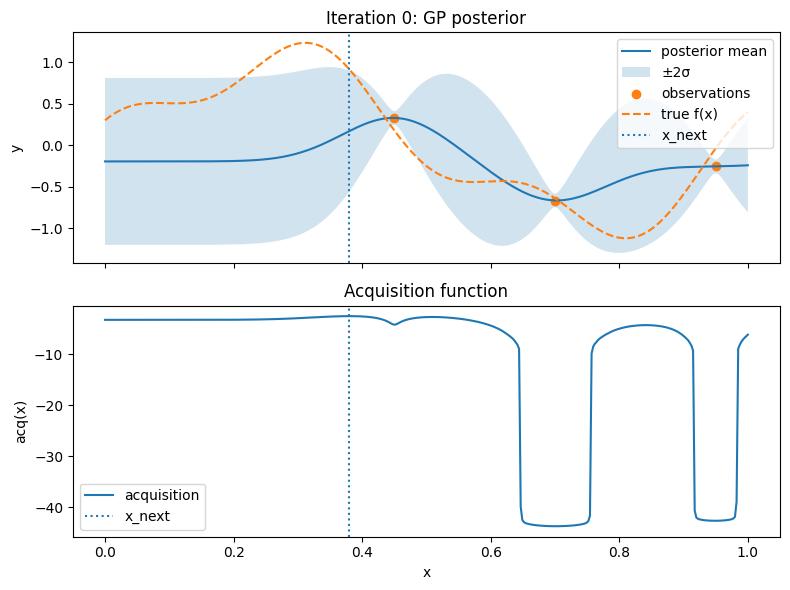

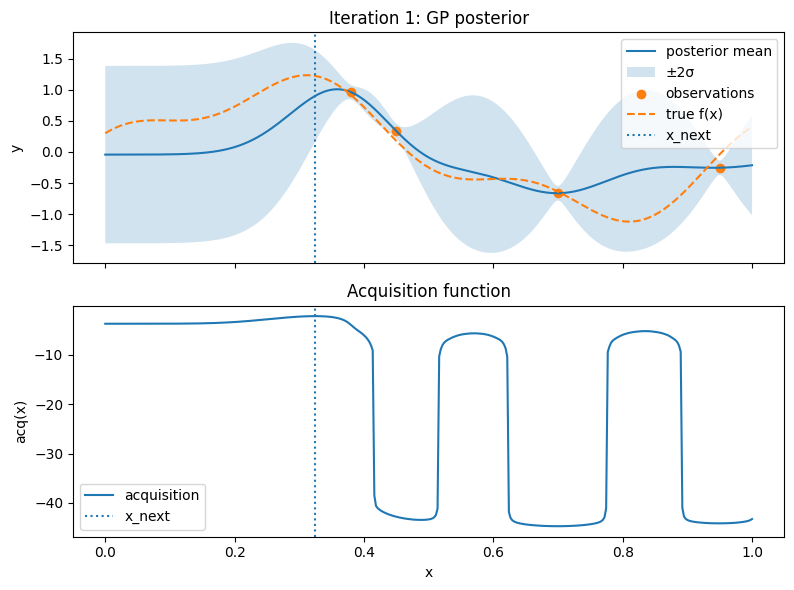

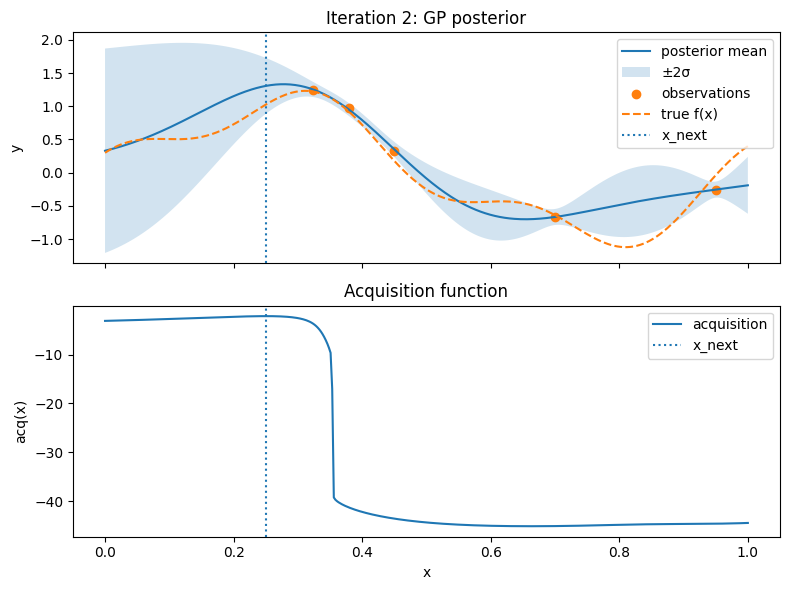

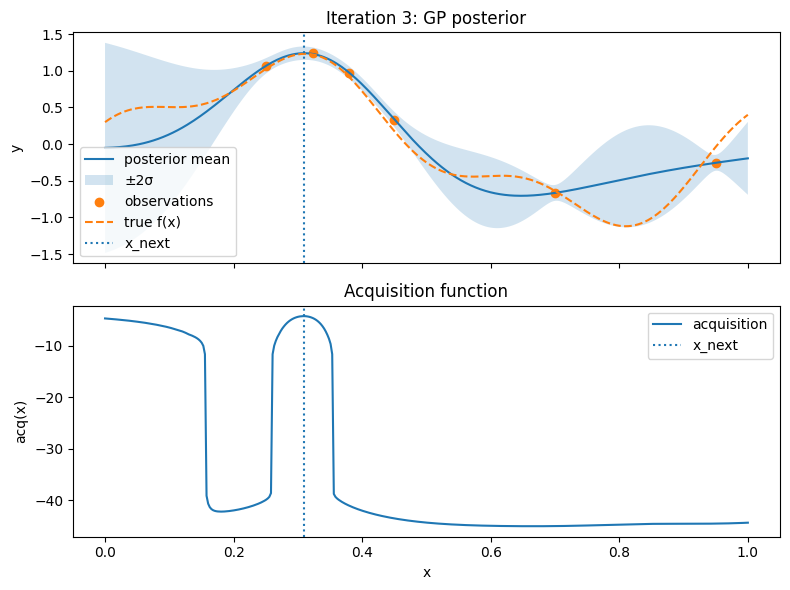

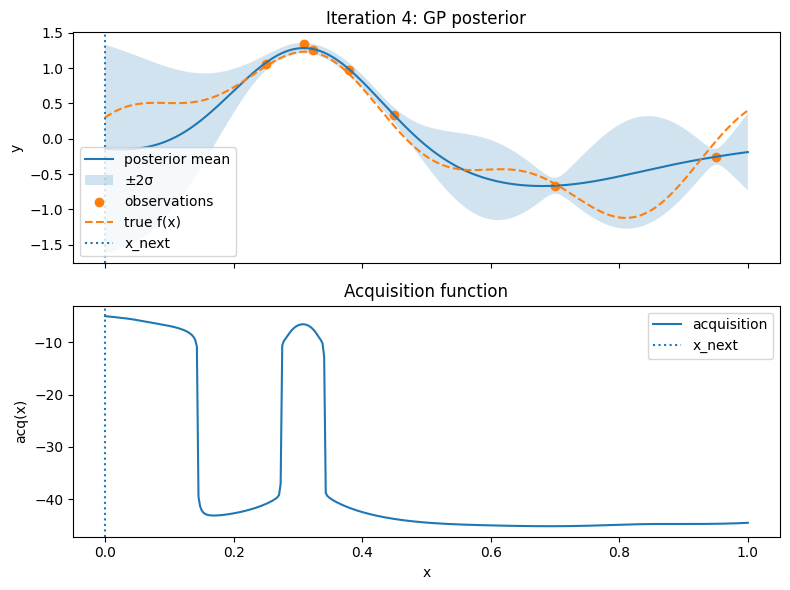

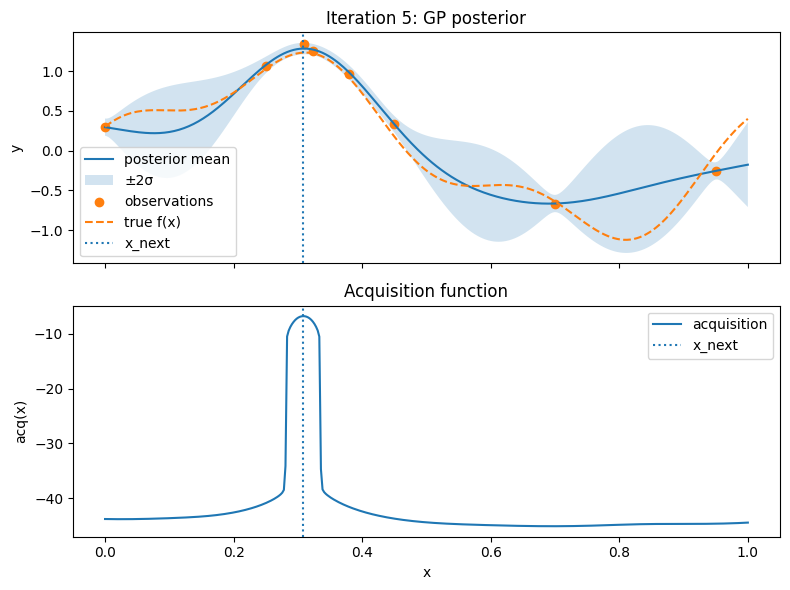

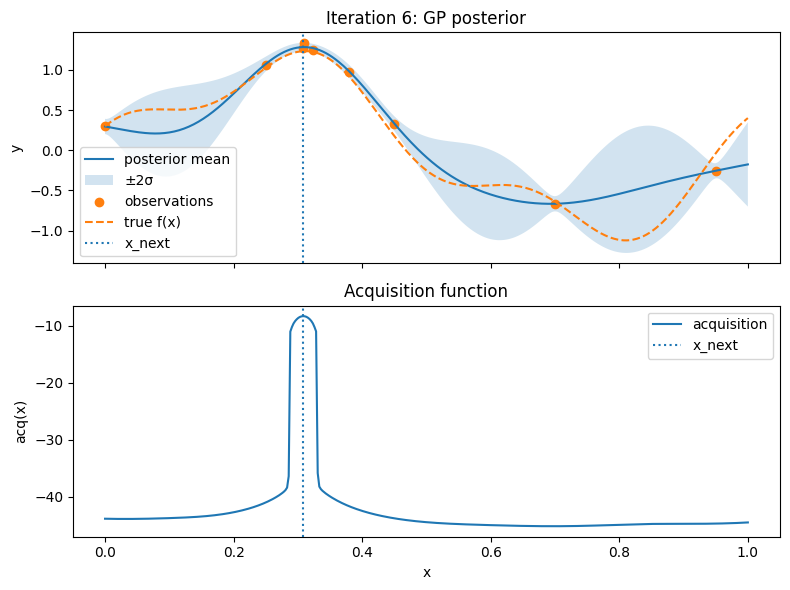

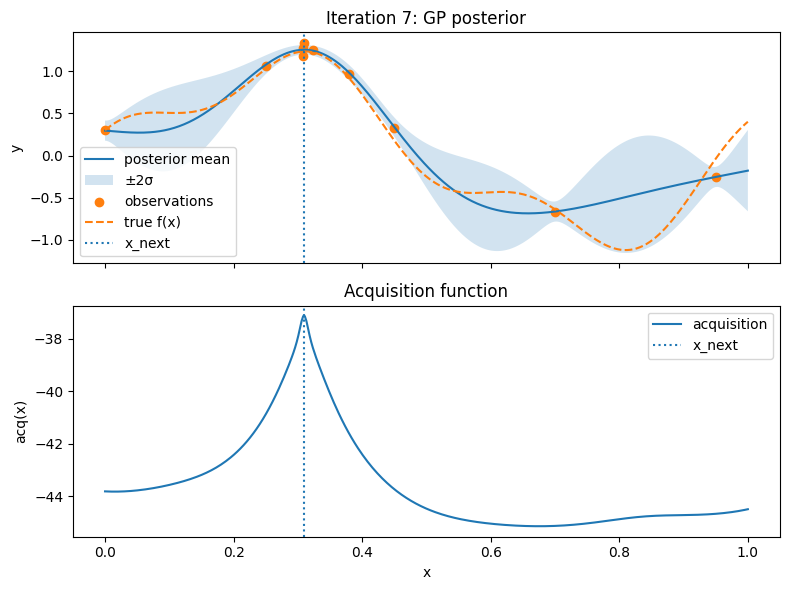

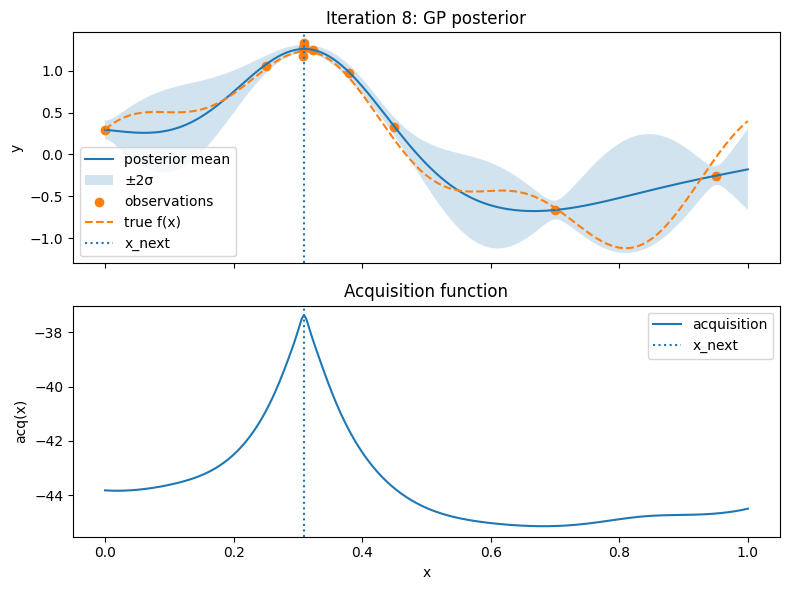

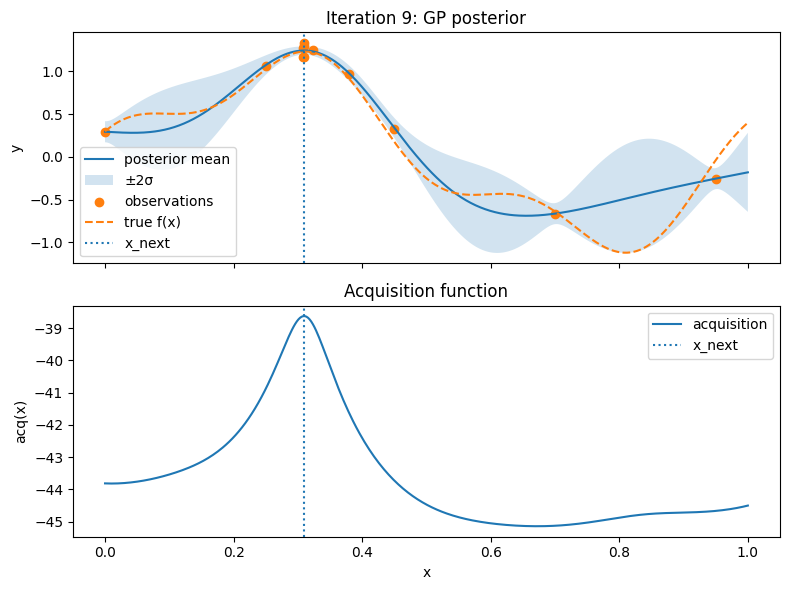

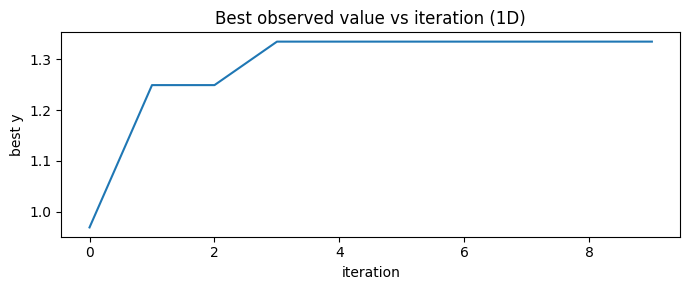

In [26]:
import torch
import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.optim import optimize_acqf


def fit_gp_1d(train_X: torch.Tensor, train_Y: torch.Tensor) -> SingleTaskGP:
    model = SingleTaskGP(
        train_X,
        train_Y,
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


def plot_gp_and_acq_1d(
    model,
    acq,
    X,
    Y,
    bounds,
    iteration: int,
    X_next=None,
    true_f=None,
    n_grid: int = 400,
):
    model.eval()
    lb = bounds[0, 0].item()
    ub = bounds[1, 0].item()
    X_grid = torch.linspace(lb, ub, n_grid, **tkwargs).unsqueeze(-1)

    with torch.no_grad():
        post = model.posterior(X_grid)
        mean = post.mean.squeeze(-1)
        std = post.variance.sqrt().squeeze(-1)

        acq_vals = acq(X_grid.unsqueeze(-2)).squeeze(-1)  

        if true_f is not None:
            y_true = true_f(X_grid).squeeze(-1)
        else:
            y_true = None

    # Move to CPU numpy for plotting
    xg = X_grid.squeeze(-1).detach().cpu().numpy()
    m = mean.detach().cpu().numpy()
    s = std.detach().cpu().numpy()
    xa = acq_vals.detach().cpu().numpy()

    x_obs = X.squeeze(-1).detach().cpu().numpy()
    y_obs = Y.squeeze(-1).detach().cpu().numpy()

    if X_next is not None:
        x_next = X_next.squeeze(-1).detach().cpu().numpy()
    else:
        x_next = None

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    ax1.plot(xg, m, label="posterior mean")
    ax1.fill_between(xg, m - 2 * s, m + 2 * s, alpha=0.2, label="±2σ")
    ax1.scatter(x_obs, y_obs, label="observations")

    if y_true is not None:
        yt = y_true.detach().cpu().numpy()
        ax1.plot(xg, yt, linestyle="--", label="true f(x)")

    if x_next is not None:
        ax1.axvline(x_next.item(), linestyle=":", label="x_next")

    ax1.set_title(f"Iteration {iteration}: GP posterior")
    ax1.set_ylabel("y")
    ax1.legend()

    ax2.plot(xg, xa, label="acquisition")
    if x_next is not None:
        ax2.axvline(x_next.item(), linestyle=":", label="x_next")
    ax2.set_title("Acquisition function")
    ax2.set_xlabel("x")
    ax2.set_ylabel("acq(x)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


def bo_loop_1d(acq_name: str = "qLogEI", n_iter: int = 8, noise_std: float = 0.10,
              plot_each_iter: bool = True):
    torch.manual_seed(0)

    X = torch.linspace(0.45, 0.95, 3, **tkwargs).unsqueeze(-1)
    Y = observe_noisy(true_f_1d(X), noise_std=noise_std)

    bounds = torch.tensor([[0.0], [1.0]], **tkwargs)
    best_hist = []

    for it in range(n_iter):
        model = fit_gp_1d(X, Y)
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

        if acq_name == "qLogEI":
            acq = qLogExpectedImprovement(model=model, best_f=Y.max(), sampler=sampler)

        X_next, _ = optimize_acqf(
            acq_function=acq,
            bounds=bounds,
            q=1,
            num_restarts=10,
            raw_samples=256,
        )
        Y_next = observe_noisy(true_f_1d(X_next), noise_std=noise_std)

        if plot_each_iter:
            # Plot using the model/acq BEFORE adding the new observation (typical BO debugging view)
            plot_gp_and_acq_1d(
                model=model,
                acq=acq,
                X=X,
                Y=Y,
                bounds=bounds,
                iteration=it,
                X_next=X_next,
                true_f=true_f_1d,   # comment this out if you don't want the ground-truth curve
                n_grid=400,
            )

        X = torch.cat([X, X_next], dim=0)
        Y = torch.cat([Y, Y_next], dim=0)
        best_hist.append(Y.max().item())

    return X, Y, best_hist


X_bo, Y_bo, best_hist = bo_loop_1d(acq_name="qLogEI", n_iter=10, noise_std=0.10, plot_each_iter=True)

plt.figure(figsize=(7, 3))
plt.plot(best_hist)
plt.title("Best observed value vs iteration (1D)")
plt.xlabel("iteration")
plt.ylabel("best y")
plt.tight_layout()
plt.show()


### 6. Full BO on Multi-Dimension Input Spaces (example with Branin function)

You are now equiped to extend the previous closed BO loop for handling multi-dimension input spaces! 

#### Excersise 6_1 

Modify the previous 1D closed loop BO to perform closed-loop BO for the optimisation of the Branin function. Code for evlauating the objective function is provided below. 

```python 
from botorch.utils.sampling import draw_sobol_samples
from botorch.test_functions import Branin

branin = Branin(negate=True).to(**tkwargs)
bounds2 = branin.bounds.to(**tkwargs)

def branin_obj(X):
    return branin(X).unsqueeze(-1)

n_init2 = 5
X_obs = draw_sobol_samples(bounds=bounds2, n=n_init2, q=1).squeeze(1).to(**tkwargs)
Y_obs = branin_obj(X_obs).to(**tkwargs)
```

In [28]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.test_functions import Branin

branin = Branin(negate=True).to(**tkwargs)
bounds2 = branin.bounds.to(**tkwargs)

def branin_obj(X):
    return branin(X).unsqueeze(-1)

n_init2 = 20
X_obs = draw_sobol_samples(bounds=bounds2, n=n_init2, q=1).squeeze(1).to(**tkwargs)
Y_obs = branin_obj(X_obs).to(**tkwargs)

model2d = SingleTaskGP(
    X_obs, Y_obs,
    input_transform=Normalize(d=2),
    outcome_transform=Standardize(m=1),
).to(**tkwargs)
mll2d = ExactMarginalLogLikelihood(model2d.likelihood, model2d)
fit_gpytorch_mll(mll2d)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

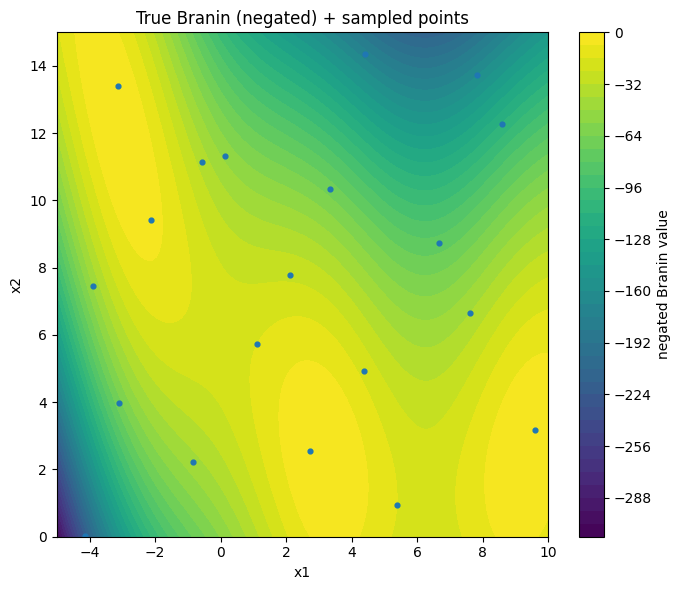

In [29]:

nx = 140
x1 = torch.linspace(bounds2[0,0], bounds2[1,0], nx, **tkwargs)
x2 = torch.linspace(bounds2[0,1], bounds2[1,1], nx, **tkwargs)
X1, X2_grid = torch.meshgrid(x1, x2, indexing="ij")
grid2 = torch.stack([X1, X2_grid], dim=-1).reshape(-1, 2)

with torch.no_grad():
    Z_true = branin_obj(grid2).squeeze(-1).reshape(nx, nx)

plt.figure(figsize=(7, 6))
plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), Z_true.cpu().numpy(), levels=40)
plt.colorbar(label="negated Branin value")
plt.scatter(X_obs.cpu().numpy()[:,0], X_obs.cpu().numpy()[:,1], s=12)
plt.title("True Branin (negated) + sampled points")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()


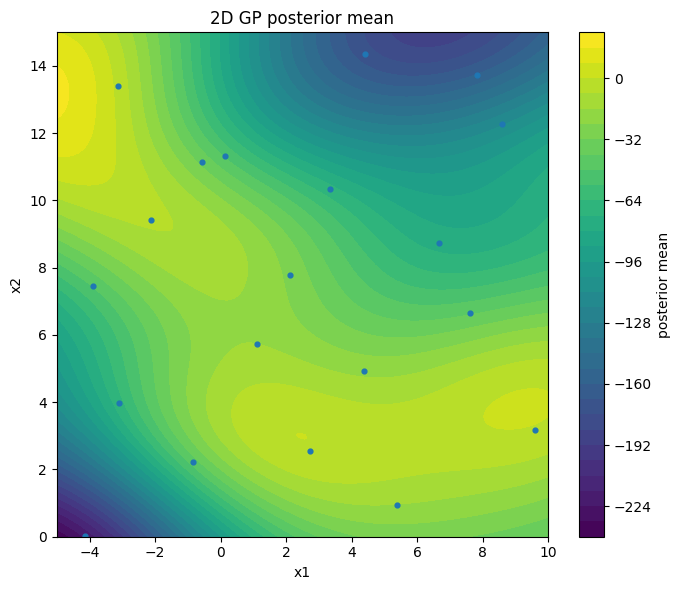

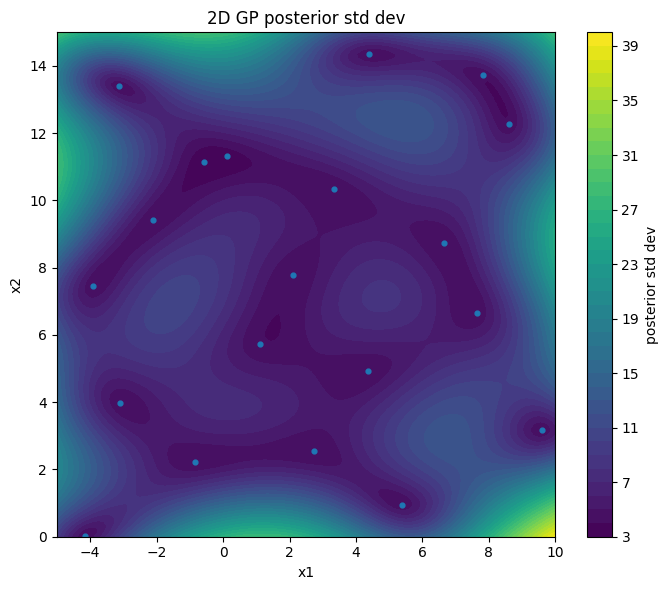

In [30]:

model2d.eval()
with torch.no_grad():
    post = model2d.posterior(grid2)
    mu2 = post.mean.squeeze(-1).reshape(nx, nx)
    sd2 = post.variance.sqrt().squeeze(-1).reshape(nx, nx)

plt.figure(figsize=(7, 6))
plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), mu2.cpu().numpy(), levels=40)
plt.colorbar(label="posterior mean")
plt.scatter(X_obs.cpu().numpy()[:,0], X_obs.cpu().numpy()[:,1], s=12)
plt.title("2D GP posterior mean")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), sd2.cpu().numpy(), levels=40)
plt.colorbar(label="posterior std dev")
plt.scatter(X_obs.cpu().numpy()[:,0], X_obs.cpu().numpy()[:,1], s=12)
plt.title("2D GP posterior std dev")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()


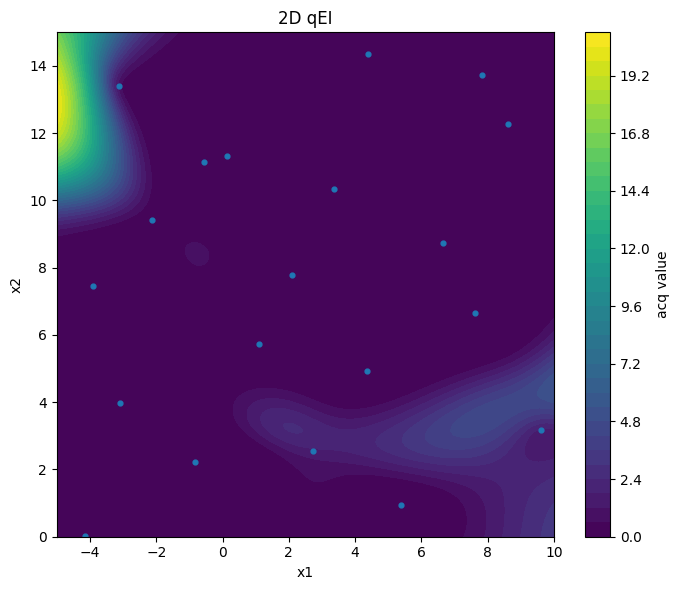

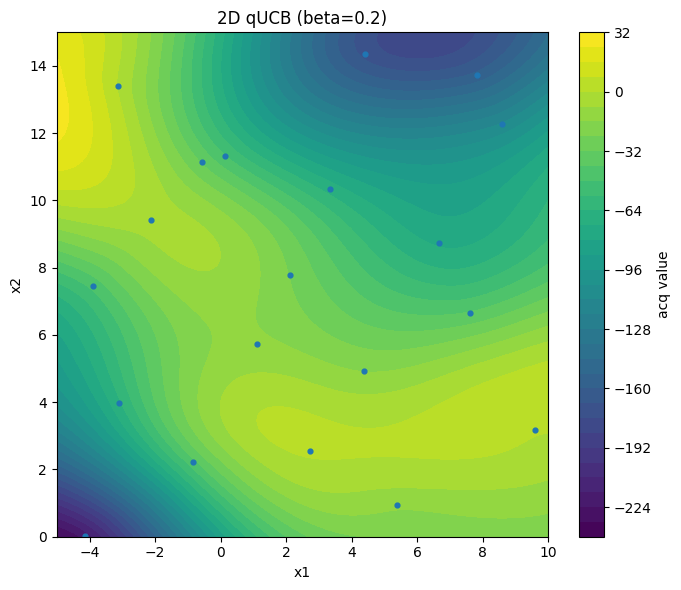

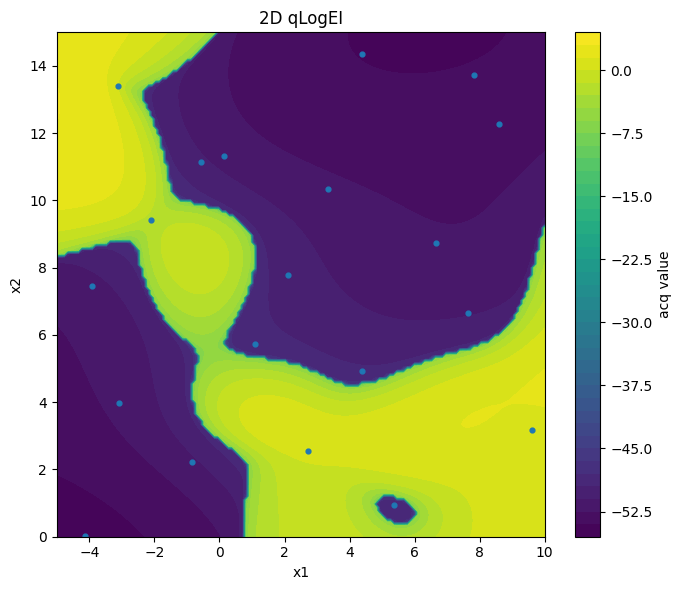

In [32]:

def eval_acq_2d(acqf):
    with torch.no_grad():
        A = acqf(grid2.unsqueeze(1)).reshape(nx, nx)
    return A

def plot_acq_2d(acqf, title: str):
    A = eval_acq_2d(acqf)
    plt.figure(figsize=(7, 6))
    plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), A.cpu().numpy(), levels=40)
    plt.colorbar(label="acq value")
    plt.scatter(X_obs.cpu().numpy()[:,0], X_obs.cpu().numpy()[:,1], s=12)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))
best_f2 = Y_obs.max()

qei2 = qExpectedImprovement(model=model2d, best_f=best_f2, sampler=sampler)
qucb2 = qUpperConfidenceBound(model=model2d, beta=0.2, sampler=sampler)

plot_acq_2d(qei2, "2D qEI")
plot_acq_2d(qucb2, "2D qUCB (beta=0.2)")


qlogei2 = qLogExpectedImprovement(model=model2d, best_f=best_f2, sampler=sampler)
plot_acq_2d(qlogei2, "2D qLogEI")


x_next: [[-5.         12.89544419]] y_next: -31.14429653190013


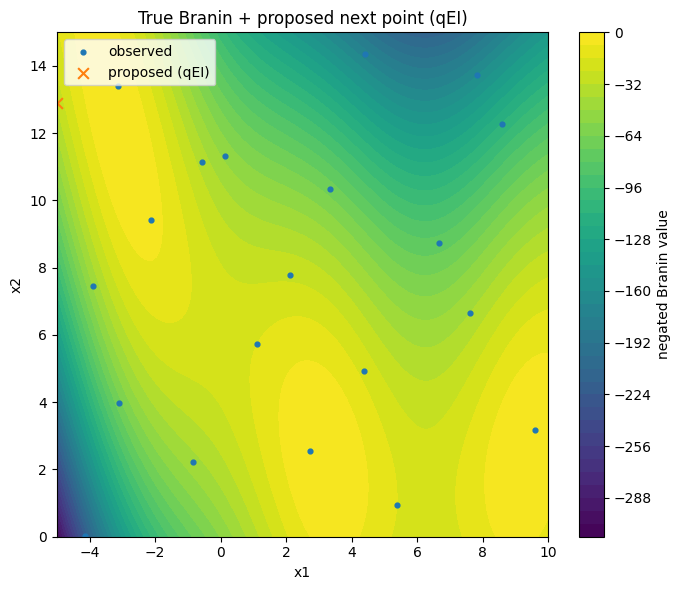

In [34]:
x_next, _ = optimize_acqf(qei2, bounds=bounds2, q=1, num_restarts=15, raw_samples=1024)
y_next = branin_obj(x_next)

print("x_next:", x_next.detach().cpu().numpy(), "y_next:", y_next.item())

plt.figure(figsize=(7, 6))
plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), Z_true.cpu().numpy(), levels=40)
plt.colorbar(label="negated Branin value")
plt.scatter(X_obs.cpu().numpy()[:,0], X_obs.cpu().numpy()[:,1], s=12, label="observed")
plt.scatter(x_next.detach().cpu().numpy()[:,0], x_next.detach().cpu().numpy()[:,1], s=60, marker="x", label="proposed (qEI)")
plt.title("True Branin + proposed next point (qEI)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()


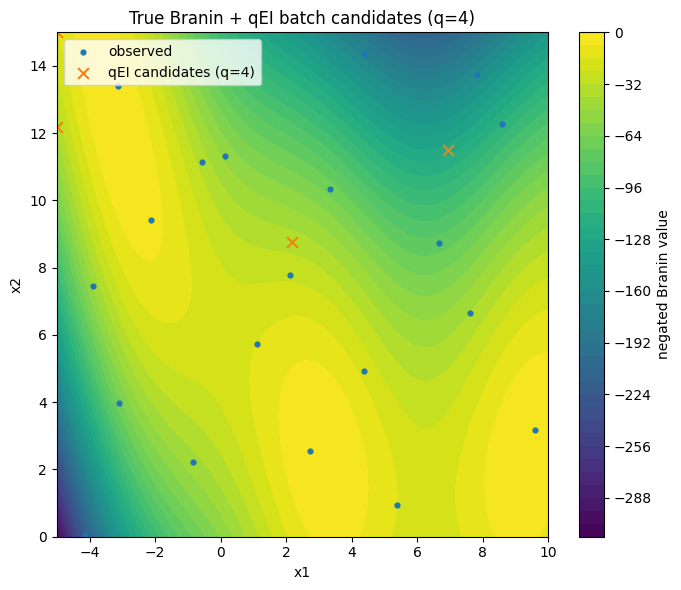

In [35]:

x_next4, _ = optimize_acqf(qei2, bounds=bounds2, q=4, num_restarts=20, raw_samples=2048)

plt.figure(figsize=(7, 6))
plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), Z_true.cpu().numpy(), levels=40)
plt.colorbar(label="negated Branin value")
plt.scatter(X_obs.cpu().numpy()[:,0], X_obs.cpu().numpy()[:,1], s=12, label="observed")
plt.scatter(x_next4.detach().cpu().numpy()[:,0], x_next4.detach().cpu().numpy()[:,1], s=60, marker="x", label="qEI candidates (q=4)")
plt.title("True Branin + qEI batch candidates (q=4)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()


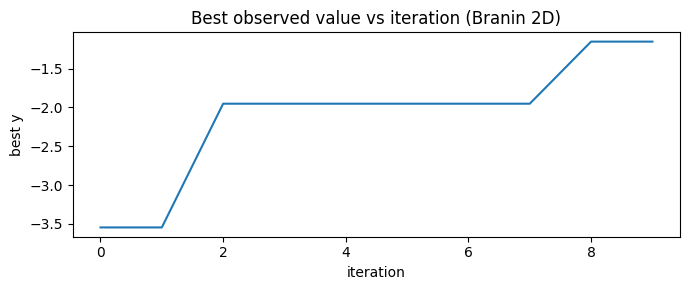

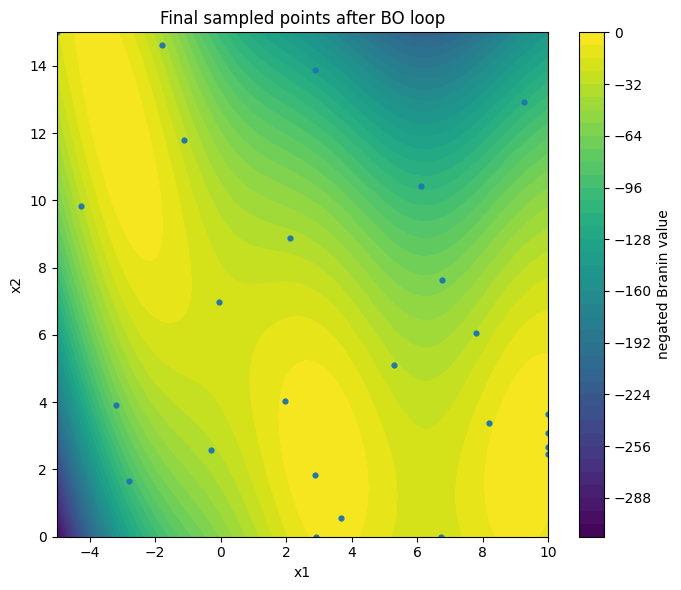

In [37]:
def fit_gp_2d(X, Y):
    model = SingleTaskGP(
        X, Y,
        input_transform=Normalize(d=2),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

def bo_loop_branin(n_iter=8, acq_name="qLogEI"):
    torch.manual_seed(0)
    X = draw_sobol_samples(bounds=bounds2, n=15, q=1).squeeze(1).to(**tkwargs)
    Y = branin_obj(X)

    best_hist = []

    for it in range(n_iter):
        model = fit_gp_2d(X, Y)
        model.eval()
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

        best_f = Y.max()
        if acq_name == "qLogEI" :
            acq = qLogExpectedImprovement(model=model, best_f=best_f, sampler=sampler)
        else:
            acq = qExpectedImprovement(model=model, best_f=best_f, sampler=sampler)

        X_next, _ = optimize_acqf(acq, bounds=bounds2, q=1, num_restarts=15, raw_samples=1024)
        Y_next = branin_obj(X_next)

        X = torch.cat([X, X_next], dim=0)
        Y = torch.cat([Y, Y_next], dim=0)
        best_hist.append(Y.max().item())

    return X, Y, best_hist

Xb, Yb, best_hist2 = bo_loop_branin(n_iter=10, acq_name="qLogEI")

plt.figure(figsize=(7, 3))
plt.plot(best_hist2)
plt.title("Best observed value vs iteration (Branin 2D)")
plt.xlabel("iteration")
plt.ylabel("best y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.contourf(X1.cpu().numpy(), X2_grid.cpu().numpy(), Z_true.cpu().numpy(), levels=40)
plt.colorbar(label="negated Branin value")
plt.scatter(Xb.cpu().numpy()[:,0], Xb.cpu().numpy()[:,1], s=12)
plt.title("Final sampled points after BO loop")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()
